In [1]:
import gensim
import nltk
import re
import codecs
import itertools
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
clean_texts = pd.read_csv('clean_dataset')

In [3]:
clean_texts

,Unnamed: 0,text,choose_one,class_label,tokens
0,0,just happened a terrible car crash,Relevant,1,"['just', 'happened', 'a', 'terrible', 'car', '..."
1,1,our deeds are the reason of this earthquake m...,Relevant,1,"['our', 'deeds', 'are', 'the', 'reason', 'of',..."
2,2,"heard about earthquake is different cities, s...",Relevant,1,"['heard', 'about', 'earthquake', 'is', 'differ..."
3,3,"there is a forest fire at spot pond, geese are...",Relevant,1,"['there', 'is', 'a', 'forest', 'fire', 'at', '..."
4,4,forest fire near la ronge sask canada,Relevant,1,"['forest', 'fire', 'near', 'la', 'ronge', 'sas..."
...,...,...,...,...,...
10673,10866,suicide bomber kills 15 in saudi security site...,Relevant,1,"['suicide', 'bomber', 'kills', '15', 'in', 'sa..."
10674,10868,green line derailment in chicago,Relevant,1,"['green', 'line', 'derailment', 'in', 'chicago']"
10675,10869,two giant cranes holding a bridge collapse int...,Relevant,1,"['two', 'giant', 'cranes', 'holding', 'a', 'br..."
10676,10873,the latest more homes razed by northern calif...,Relevant,1,"['the', 'latest', 'more', 'homes', 'razed', 'b..."


In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
count_vectorizer = CountVectorizer()

In [6]:
list_corpus = clean_texts['text'].tolist()
list_label = clean_texts['class_label'].tolist()

In [7]:
X_train,X_test,y_train,y_test = train_test_split(list_corpus,list_label,test_size=0.2)

In [8]:
X_train_counts = count_vectorizer.fit_transform(X_train)

In [9]:
X_train_counts.shape

(8542, 15782)

In [10]:
X_test_counts = count_vectorizer.transform(X_test)

In [11]:
X_test_counts.shape

(2136, 15782)

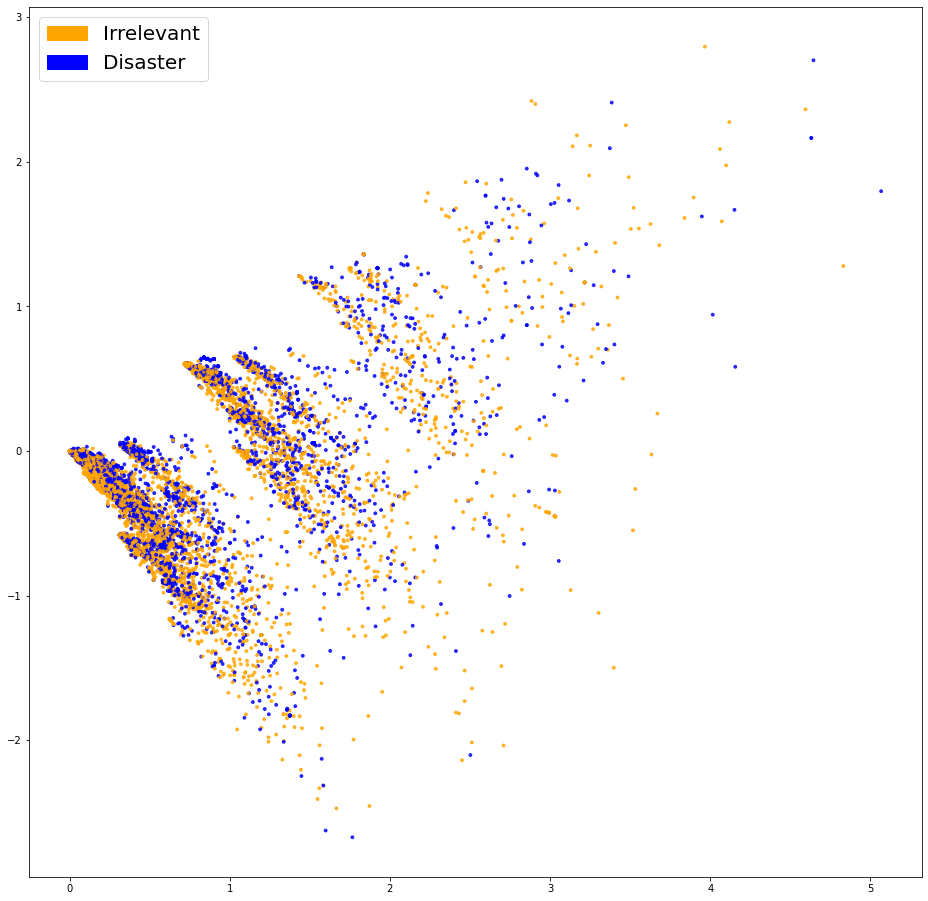

In [12]:
def plot_LSA(test_data, test_label, savepath="PCA_demo.csv",plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.fit_transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_label))}
    color_column = [color_mapper[label] for label in test_label]
    colors = ['orange','blue','blue']
    if plot:
        
        plt.scatter(lsa_scores[:,0],lsa_scores[:,1],s=8,alpha=0.8,c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        blue_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch,blue_patch],prop={'size':20})
        

plt.figure(figsize=(16,16))
plot_LSA(X_train_counts,y_train)
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
Log_clf = LogisticRegression(C=30,class_weight='balanced',solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40)
Log_clf.fit(X_train_counts,y_train)

y_predict_counts = Log_clf.predict(X_test_counts)

In [15]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

In [16]:
def get_metrics(y_test,y_predict):
    precision = precision_score(y_test,y_predict,pos_label=None,average='weighted')
    recall = recall_score(y_test,y_predict,pos_label=None,average='weighted')
    accuracy = accuracy_score(y_test,y_predict)
    f1 = f1_score(y_test,y_predict,pos_label=None,average='weighted')
    
    return precision,recall,accuracy,f1

In [17]:
precision, recall, accuracy, f1 = get_metrics(y_test,y_predict_counts)
print("accuracy =  {:.2f}\n precision = {:.2f}\n recall = {:.2f}\n f1 = {:.2f}".format(accuracy,precision,recall,f1))

accuracy =  0.77
 precision = 0.77
 recall = 0.77
 f1 = 0.77


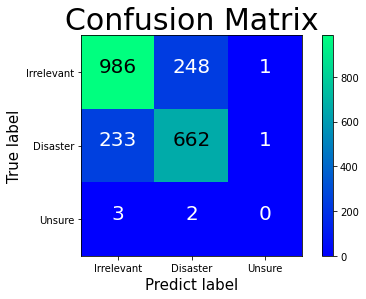

In [18]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap =plt.cm.winter):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,fontsize=10)
    plt.yticks(tick_marks,classes,fontsize=10)
    fmt= '.2f' if normalize else 'd'
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(i,j,format(cm[i,j],fmt),horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.xlabel('Predict label',fontsize=15)
    plt.ylabel('True label',fontsize=15)
    
    return plt

cm = confusion_matrix(y_test,y_predict_counts)
plot_confusion_matrix(cm,['Irrelevant','Disaster','Unsure'])
plt.show()

In [19]:
# Método para identificação das features mais importantes na tomada de decisão. 
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    return classes 
importance = get_most_important_features(count_vectorizer, Log_clf, 10)

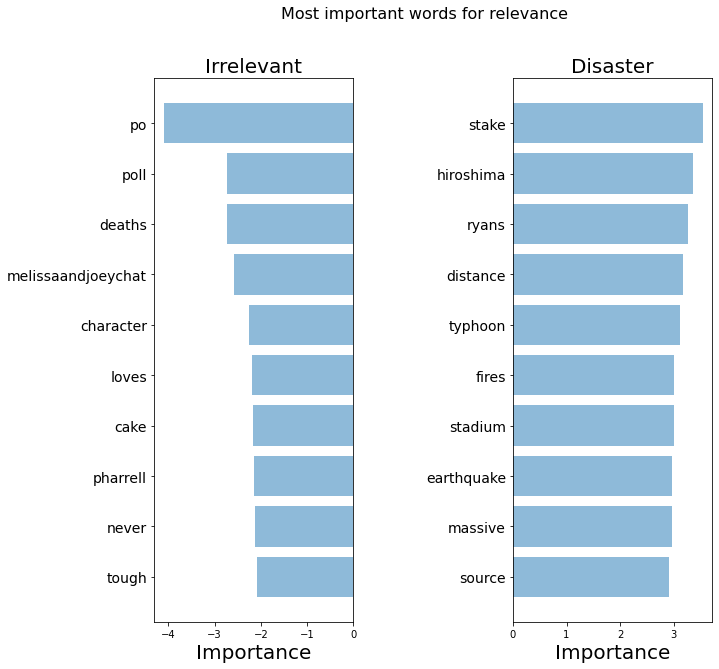

In [20]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]        
    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

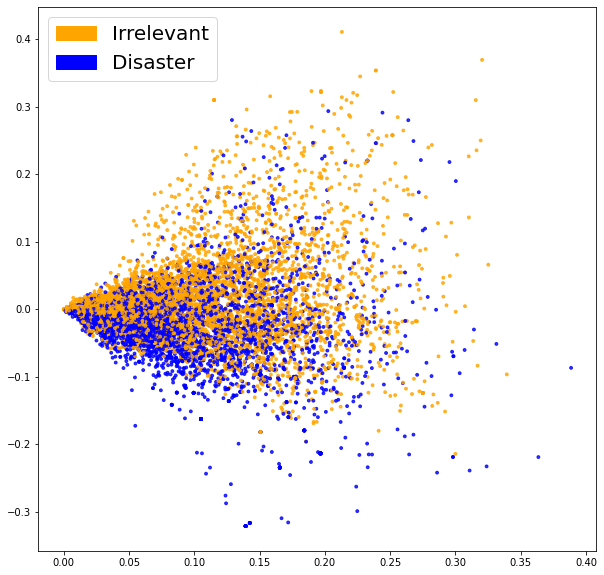

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(10,10))
plot_LSA(X_train_tfidf,y_train)
plt.show()

In [22]:
clf_tfidf = LogisticRegression(C=30, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

clf_tfidf.fit(X_train_tfidf,y_train)
y_predict_tfidf=clf_tfidf.predict(X_test_tfidf)

In [23]:
precision, recall, accuracy, f1 = get_metrics(y_test,y_predict_tfidf)
print("accuracy =  {:.2f}\n precision = {:.2f}\n recall = {:.2f}\n f1 = {:.2f}".format(accuracy,precision,recall,f1))

accuracy =  0.78
 precision = 0.78
 recall = 0.78
 f1 = 0.78


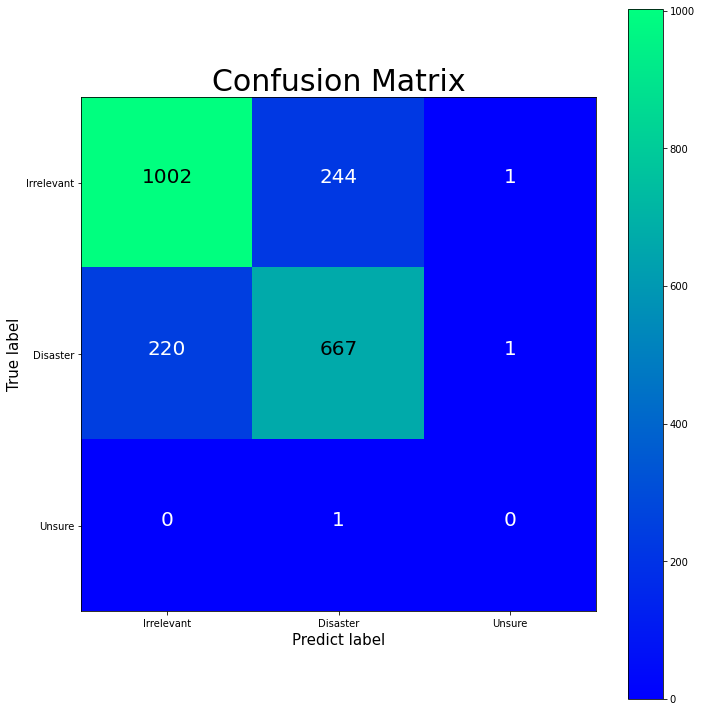

In [24]:
cm_tfidf= confusion_matrix(y_test,y_predict_tfidf)
fig= plt.figure(figsize=(10,10))
plot_confusion_matrix(cm_tfidf,['Irrelevant','Disaster','Unsure'])
plt.show()

In [25]:
importance_tfidf = get_most_important_features(tfidf_vectorizer,clf_tfidf,10)

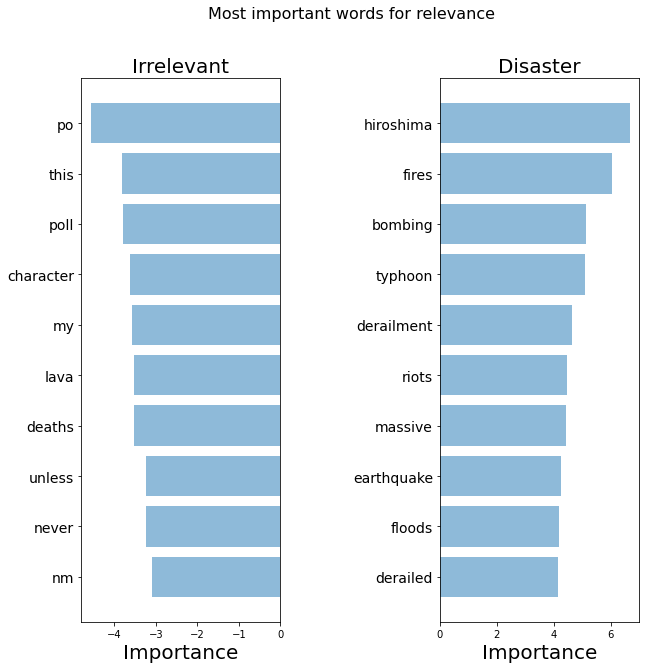

In [26]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [27]:
import gensim

In [30]:
word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [31]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
       return np.zeros(k)    
    if generate_missing:        
       vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
       vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    return averaged 
#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    return list(embeddings)

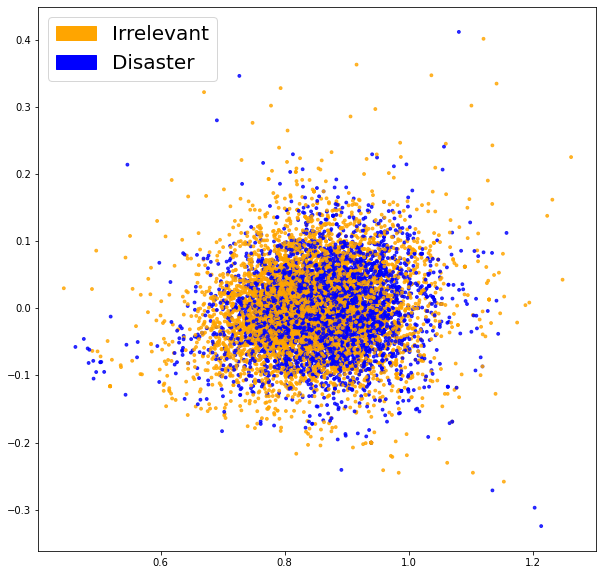

In [35]:
embeddings = get_word2vec_embeddings(word2vec, clean_texts) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_label,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_label) 
plt.show()

In [36]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [37]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

accuracy = 0.630, precision = 0.537, recall = 0.537, f1 = 0.578


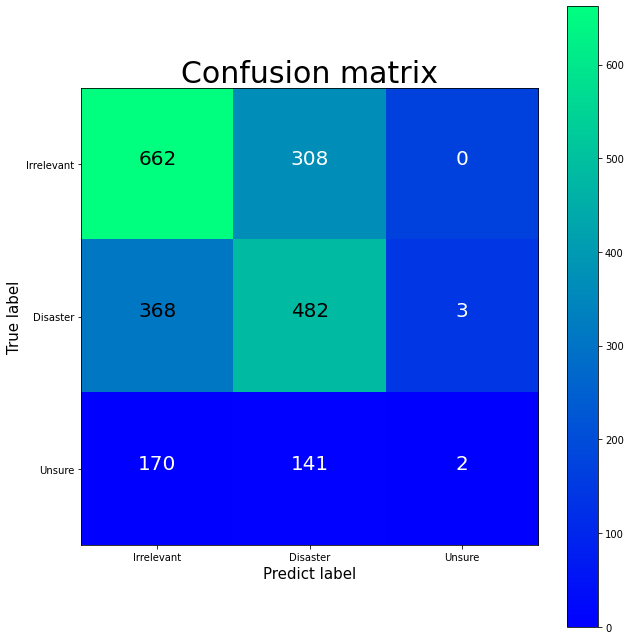

Word2Vec confusion matrix
[[662 368 170]
 [308 482 141]
 [  0   3   2]]
TFIDF confusion matrix
[[1002  220    0]
 [ 244  667    1]
 [   1    1    0]]
BoW confusion matrix
[[986 233   3]
 [248 662   2]
 [  1   1   0]]


In [42]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) 
print("TFIDF confusion matrix") 
print(cm_tfidf) 
print("BoW confusion matrix") 
print(cm)